<a href="https://colab.research.google.com/github/urvigodha/Viral_Tweets/blob/main/Viral10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score,accuracy_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
# from catboost import CatBoostClassifier

In [127]:
train = pd.read_csv('/content/drive/MyDrive/Viral Tweets Prediction Challenge Dataset/train.csv',index_col=0)
test = pd.read_csv('/content/drive/MyDrive/Viral Tweets Prediction Challenge Dataset/test.csv',index_col=0)
Y = pd.read_csv('/content/drive/MyDrive/Viral Tweets Prediction Challenge Dataset/Dataset/Tweets/train_tweets.csv').virality
print(train.shape)
print(Y.shape)
print(test.shape)

(29625, 24)
(29625,)
(12697, 24)


In [128]:
def boolean_df(item_lists, unique_items):
# Create empty dict
    bool_dict = {}
    
    # Loop through all the tags
    for i, item in enumerate(unique_items):
        
        # Apply boolean mask
        bool_dict[item] = item_lists.apply(lambda x: item in x)
            
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

def to_1D(series):
 return pd.Series([x for _list in series for x in _list])

In [129]:
test.tweet_topic_ids = test.fillna('[]').tweet_topic_ids.apply(eval)
train.tweet_topic_ids = train.fillna('[]').tweet_topic_ids.apply(eval)
topics = set(to_1D(test.tweet_topic_ids).unique().tolist()+to_1D(train.tweet_topic_ids).unique().tolist())
train_topics_bool = boolean_df(train['tweet_topic_ids'], topics)
test_topics_bool = boolean_df(test['tweet_topic_ids'], topics)
test = pd.concat([test, test_topics_bool],axis=1)
train = pd.concat([train, train_topics_bool], axis=1)

test['tweet_topic_count'] = test.tweet_topic_ids.apply(len)
train['tweet_topic_count'] = train.tweet_topic_ids.apply(len)

train.drop(columns='tweet_topic_ids', inplace=True)
test.drop(columns='tweet_topic_ids',inplace=True)

In [130]:
train.head()

,tweet_id,tweet_user_id,tweet_created_at_year,tweet_created_at_month,tweet_created_at_day,tweet_created_at_hour,tweet_hashtag_count,tweet_url_count,tweet_mention_count,tweet_has_attachment,tweet_attachment_class,tweet_language_id,user_id,user_like_count,user_followers_count,user_following_count,user_listed_on_count,user_has_location,user_tweet_count,user_has_url,user_verified,user_created_at_year,user_created_at_month,101,152,78,45,88,171,127,39,60,37,43,112,68,155,156,52,100,...,89,111,125,117,119,172,163,72,151,44,58,91,59,126,87,104,73,118,61,80,93,63,170,149,169,82,165,122,99,98,38,123,147,36,79,81,120,148,153,tweet_topic_count
0,34698.0,10.0,2015.0,12.0,5.0,3.0,2.0,1.0,0.0,False,C,0.0,10,9365,398591,136081,18462,True,169980,True,0,2011,10,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,12
1,24644.0,4.0,2020.0,6.0,19.0,0.0,0.0,1.0,0.0,False,C,0.0,4,15311,459083,1021,7368,False,121193,False,0,2011,6,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,...,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False,False,False,False,True,False,False,False,False,9
2,36321.0,54.0,2019.0,6.0,2.0,15.0,2.0,3.0,0.0,True,A,0.0,54,336,447110,584,10519,True,3786,True,0,2011,12,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False,False,False,False,True,False,False,False,False,11
3,2629.0,42.0,2020.0,9.0,6.0,17.0,0.0,1.0,1.0,True,A,0.0,42,1124,276541,758,6163,True,3264,True,0,2011,9,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False,False,False,False,True,False,False,False,False,8
4,28169.0,32.0,2020.0,11.0,4.0,17.0,2.0,1.0,0.0,True,A,0.0,32,0,1587783,2,16414,False,2022,True,0,2013,7,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False,False,False,False,True,False,False,False,False,6


In [131]:
train['tweet_created_at_date'] = pd.to_datetime(train.tweet_created_at_year*10000+train.tweet_created_at_month*100+train.tweet_created_at_day,format='%Y%m%d').dt.dayofweek
test['tweet_created_at_date'] = pd.to_datetime(test.tweet_created_at_year*10000+test.tweet_created_at_month*100+test.tweet_created_at_day,format='%Y%m%d').dt.dayofweek

In [132]:
test.tweet_attachment_class = test.tweet_attachment_class.map({'A':1,'B':2,'C':3})
train.tweet_attachment_class = train.tweet_attachment_class.map({'A':1,'B':2,'C':3})

In [133]:
train['user_years'] = train.tweet_created_at_year - train.user_created_at_year   #useful
train['user_ratio']=train.user_followers_count / train.user_following_count.replace(0,1)
train['eng'] = (train['tweet_language_id']==0)  # not very useful (for rf atleast)

test['user_years'] = test.tweet_created_at_year - test.user_created_at_year   #useful
test['user_ratio']=test.user_followers_count / test.user_following_count.replace(0,1)
test['eng'] = (test['tweet_language_id']==0)  # not very useful (for rf atleast)

In [134]:
train['virality'] = Y
virality_user = train.groupby(['user_id','virality']).count().tweet_id.unstack().fillna(0)
for i in range(1,6):
  virality_user[i] = virality_user[i]*100/train.groupby(['user_id']).count().tweet_id
cols = []
for i in range(1,6):
  cols.append('virality_user_'+str(i))
train = pd.concat([train,pd.DataFrame(columns=cols)])
test = pd.concat([test,pd.DataFrame(columns=cols)])
for i in range(train.shape[0]):
  train.loc[i,'virality_user_1':'virality_user_5'] = virality_user.loc[train.user_id[i]].tolist()
for i in range(test.shape[0]):
  test.loc[i,'virality_user_1':'virality_user_5'] = virality_user.loc[test.user_id[i]].tolist()

median_virality = train.groupby(['user_id']).median().virality
for i in train.index:
  train.loc[i,'median_virality'] = median_virality[train.user_id[i]]

for i in test.index:
  test.loc[i,'median_virality'] = median_virality[test.user_id[i]]
train.drop('virality',axis=1,inplace=True)

In [104]:
print(train.shape)
print(test.shape)

(29625, 93)
(12697, 93)


In [113]:
X_train, X_test, y_train, y_test = train_test_split(train, Y, test_size=0.3)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(20737, 93)
(8888, 93)
(20737,)
(8888,)


Text(0.5, 0, 'Random Forest Feature Importance')

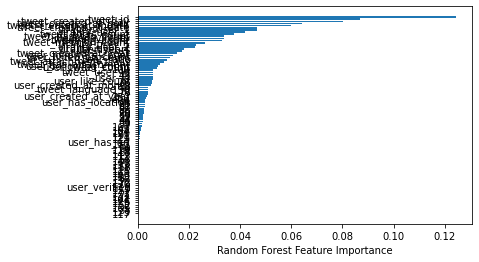

In [135]:
rf = RandomForestClassifier()
rf.fit(train,Y)
sorted_idx = rf.feature_importances_.argsort()
plt.barh(train.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [114]:
clf = RandomForestClassifier()
clf.fit(X_train,y_train)
print('Train: ',clf.score(X_train,y_train))
print('Test: ',clf.score(X_test,y_test))

Train:  1.0
Test:  0.676980198019802


In [124]:
train = train[train.columns[sorted_idx[80:]]]
X_train, X_test, y_train, y_test = train_test_split(train, Y, test_size=0.3)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(20737, 13)
(8888, 13)
(20737,)
(8888,)


In [125]:
clf = RandomForestClassifier()
clf.fit(X_train,y_train)
print('Train: ',clf.score(X_train,y_train))
print('Test: ',clf.score(X_test,y_test))

Train:  0.9999517770169263
Test:  0.666966696669667


In [136]:
train = train[train.columns[sorted_idx[50:]]]
X_train, X_test, y_train, y_test = train_test_split(train, Y, test_size=0.3)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
clf = RandomForestClassifier()
clf.fit(X_train,y_train)
print('Train: ',clf.score(X_train,y_train))
print('Test: ',clf.score(X_test,y_test))

(20737, 43)
(8888, 43)
(20737,)
(8888,)
Train:  1.0
Test:  0.6704545454545454


In [138]:
test = test[test.columns[sorted_idx[50:]]]

In [139]:
clf = RandomForestClassifier(1200,max_depth= 25,min_samples_leaf= 1,min_samples_split= 10)
clf.fit(train,Y)
sol = test.tweet_id.to_frame()
sol['virality'] = clf.predict(test)
sol.astype(int).to_csv('sol7.csv',index=False)

In [111]:
pd.DataFrame(train.columns[sorted_idx], rf.feature_importances_[sorted_idx]).head(50)

,0
0.000000,117
0.000000,123
0.000000,38
0.000008,165
0.000026,52
0.000029,155
0.000031,126
0.000041,101
0.000048,71
0.000076,122


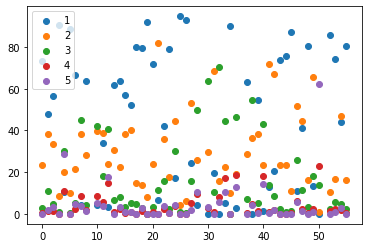

In [44]:
for i in range(1,6):
  plt.scatter(virality_user.index,virality_user[i],label=str(i))
plt.legend()
plt.show()

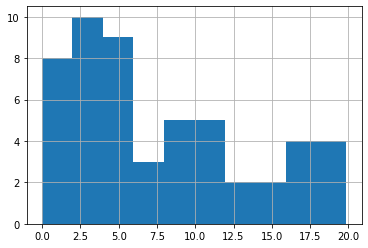

In [59]:
virality_user.T.describe().loc['50%'].hist()

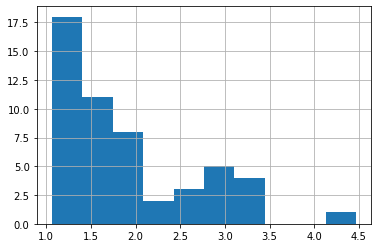

In [54]:
mean_virality.hist()